# Finding rotatable bonds in the Jnk1 ANI subset

In [6]:
from perses.utils.openeye import *
from openeye import oechem, oedepict, oegrapheme
import matplotlib.pyplot as plt
import os
import tqdm

In [2]:
rotatable_bonds = {}

for ani_index in [0, 1, 2, 4, 5, 6, 9, 10, 14, 15, 16, 17, 18]:
    mol = createOEMolFromSDF('Jnk1_ligands_shifted.sdf',index=ani_index)    
    oechem.OEAssignHybridization(mol)
    oedepict.OEPrepareDepiction(mol)
    mol.SetTitle(f'Jnk1-{ani_index}')

    opts = oedepict.OE2DMolDisplayOptions(500, 500, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)

    pen = oedepict.OEPen()
    glyph = oegrapheme.OEBondGlyphCurvedArrow(pen, 0.5)
    oegrapheme.OEAddGlyph(disp, glyph, oechem.OEIsRotor())

    oedepict.OERenderMolecule(f"Jnk1{ani_index}.png", disp)
    
    rotatables = []
    for bond in mol.GetBonds():
        if bond.IsRotor():
            rotatables.append((bond.GetBgn().GetName(), bond.GetEnd().GetName()))
            
    rotatable_bonds[ani_index] = rotatables

INFO:utils.openeye:molecule 18629-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule 18634-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule 18628-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule 18624-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule 18633-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule 18635-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule 18659-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule 18637-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule 18658-1                      does not have unique atom names. Generating now...
INFO:utils.openeye:molecule 

In [3]:
for k in rotatable_bonds.keys():
    print(k , rotatable_bonds[k])

0 [('C2', 'O1'), ('O1', 'C3'), ('C4', 'N4'), ('N4', 'C9'), ('C9', 'C10'), ('C10', 'C11')]
1 [('C2', 'O1'), ('O1', 'C3'), ('C4', 'N4'), ('N4', 'C9'), ('C9', 'C10'), ('C10', 'C11'), ('C12', 'O3'), ('C16', 'O4')]
2 [('C2', 'O1'), ('O1', 'C3'), ('C4', 'N4'), ('N4', 'C9'), ('C9', 'C10'), ('C10', 'C11')]
4 [('C2', 'O1'), ('O1', 'C3'), ('C4', 'N4'), ('N4', 'C9'), ('C9', 'C10'), ('C10', 'C11')]
5 [('C2', 'O1'), ('O1', 'C3'), ('C4', 'N4'), ('N4', 'C9'), ('C9', 'C10'), ('C10', 'C11'), ('C14', 'O3')]
6 [('C2', 'O1'), ('O1', 'C3'), ('C4', 'N4'), ('N4', 'C9'), ('C9', 'C10'), ('C10', 'C11')]
9 [('O1', 'C2'), ('C2', 'C3'), ('C3', 'O2'), ('O2', 'C4'), ('C5', 'N4'), ('N4', 'C10'), ('C10', 'C11'), ('C11', 'C12'), ('C13', 'O4'), ('C17', 'O5')]
10 [('C2', 'O1'), ('O1', 'C3'), ('C4', 'N4'), ('N4', 'C9'), ('C9', 'C10'), ('C10', 'C11'), ('C12', 'O3'), ('C15', 'N5'), ('C16', 'O4'), ('N5', 'C19')]
14 [('C1', 'C2'), ('C2', 'O2'), ('O2', 'C3'), ('C4', 'N4'), ('N4', 'C9'), ('C9', 'C10'), ('C10', 'C11'), ('C12', '

In [4]:
class IsRotatableOrMacroCycleBond(oechem.OEUnaryBondPred):
    """
    Identifies rotatable bonds and single bonds in macro-cycles.
    """
    def __call__(self, bond):
        """
        :type mol: oechem.OEBondBase
        :rtype: boolean
        """
        if bond.GetOrder() != 1:
            return False
        if bond.IsAromatic():
            return False

        isrotor = oechem.OEIsRotor()
        if isrotor(bond):
            return True

        if oechem.OEBondGetSmallestRingSize(bond) >= 10:
            return True

        return False

def get_dihedrals(mol):
    """
    Iterates over rotatable bonds and identifies their dihedral
    atoms. These atoms are added to the molecule in a group
    using the given tag.

    :type mol: oechem.OEMol
    :type itag: int
    :return: Number of dihedral angles identified
    :rtype: int
    """
    nrdihedrals = 0
    itag = 0
    for bond in mol.GetBonds(IsRotatableOrMacroCycleBond()):
        atomB = bond.GetBgn()
        atomE = bond.GetEnd()

        neighB = None
        neighE = None

        for atom in atomB.GetAtoms(oechem.OEIsHeavy()):
            if atom != atomE:
                neighB = atom
                break
        for atom in atomE.GetAtoms(oechem.OEIsHeavy()):
            if atom != atomB:
                neighE = atom
                break

        if neighB is None or neighE is None:
            continue

        atomorder = [neighB, atomB, atomE, neighE]
        bondorder = [mol.GetBond(neighB, atomB), bond, mol.GetBond(neighE, atomE)]

        if neighB.GetIdx() < neighE.GetIdx():
            atomorder.reverse()
            bondorder.reverse()

        atoms = oechem.OEAtomVector(atomorder)
        bonds = oechem.OEBondVector(bondorder)

        nrdihedrals += 1
        mol.NewGroup(itag, atoms, bonds)
        itag += 1

    return nrdihedrals, mol

def set_dihedral_histograms(mol, nrbins):
    """
    Iterates over the dihedral groups and bins the torsional
    angles for each conformation. The histogram data is then
    attached to the groups with the given tag.

    :type mol: oechem.OEMol
    :type itag: int
    :type nrbins: int
    """
    import math
    angleinc = 360.0 / float(nrbins)
    for group in mol.GetGroups():
        atoms = oechem.OEAtomVector()
        for atom in group.GetAtoms():
            atoms.append(atom)
        angles = []
        for i,conf in enumerate(mol.GetConfs()):
            rad = oechem.OEGetTorsion(conf, atoms[0], atoms[1], atoms[2], atoms[3])
            rad = (rad + np.pi) % (2 * np.pi) - np.pi
            angles.append(rad)
        group.SetData(group.GetGroupType(),angles)
    return mol

In [7]:
# need to make a mol with all of the MM samples together
ligand_0_pdbs = [x for x in os.listdir('complex_500_steps/') if x[0:3] == 'old']
for i,pdb in tqdm.tqdm(enumerate(ligand_0_pdbs)):
    if i == 0:
        mol = createOEMolFromSDF(f'complex_500_steps/{pdb}')
        n_di, x_mol = get_dihedrals(mol)
    else:
        # there absolutely must be a better/faster way of doing this because this is ugly and slow
        add_mol = createOEMolFromSDF(f'complex_500_steps/{pdb}')
        mol.NewConf(add_mol)
MM_mol = set_dihedral_histograms(x_mol,nrbins=10)


ligand_1_pdbs = [x for x in os.listdir('complex_500_steps/') if x[0:3] == 'new']
for i,pdb in enumerate(ligand_1_pdbs):
    if i == 0:
        mol = createOEMolFromSDF(f'complex_500_steps/{pdb}')
        n_di, x_mol = get_dihedrals(mol)
    else:
        add_mol = createOEMolFromSDF(f'complex_500_steps/{pdb}')
        mol.NewConf(add_mol)
ANI_mol = set_dihedral_histograms(x_mol,nrbins=10)

INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generati

In [9]:
results_MM = {}
results_ANI = {}

for group in MM_mol.GetGroups():
    dihedral_group = ' '.join([x.GetName() for x in group.GetAtoms()])
    angles = group.GetData(group.GetGroupType())
    results_MM[dihedral_group] = angles

for group in ANI_mol.GetGroups():
    dihedral_group = ' '.join([x.GetName() for x in group.GetAtoms()])
    angles = group.GetData(group.GetGroupType())
    results_ANI[dihedral_group] = angles

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


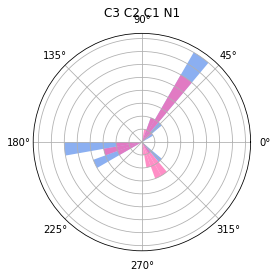

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


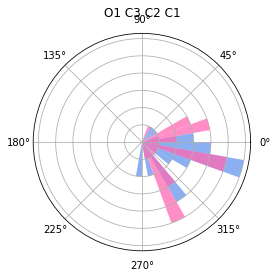

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


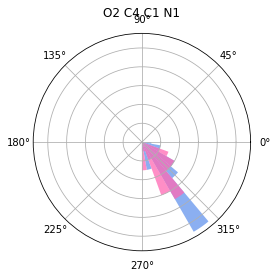

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


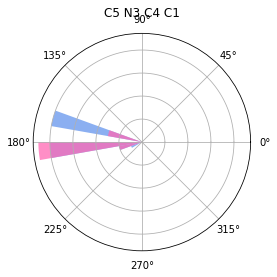

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


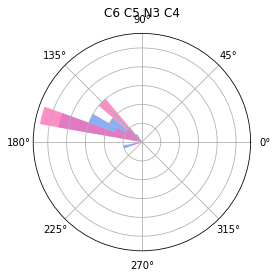

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


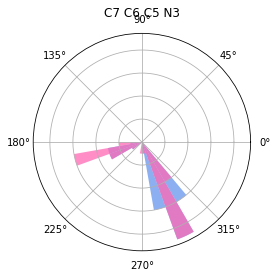

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


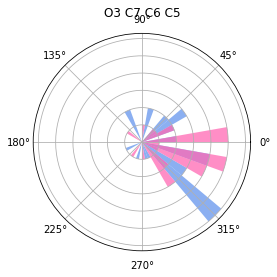

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


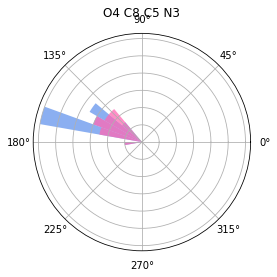

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


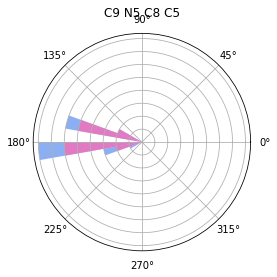

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


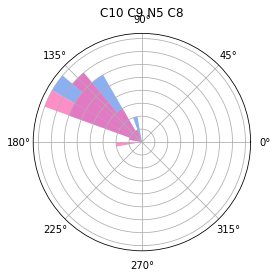

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


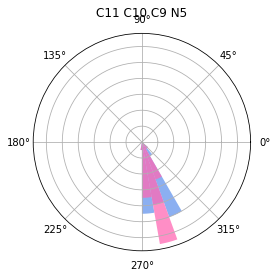

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


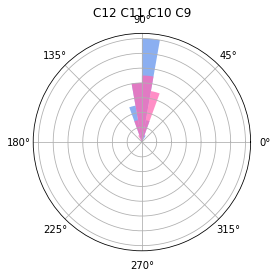

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


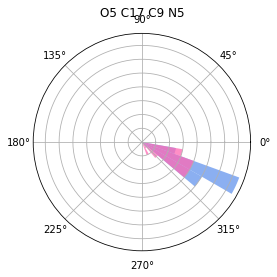

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


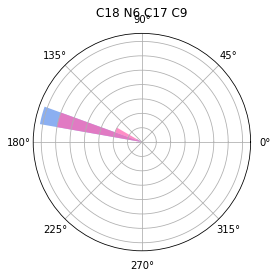

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


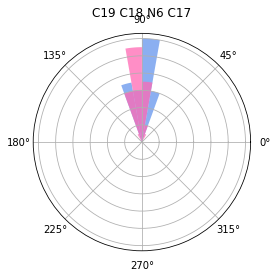

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


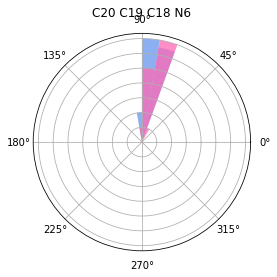

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


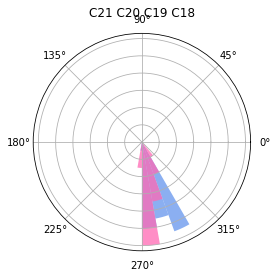

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


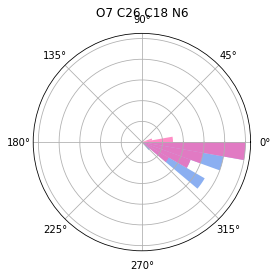

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


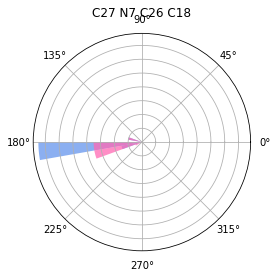

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


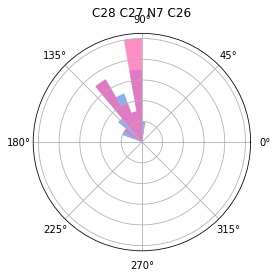

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


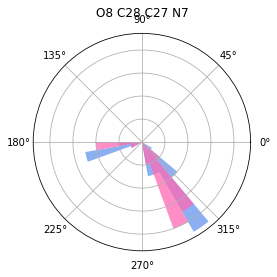

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


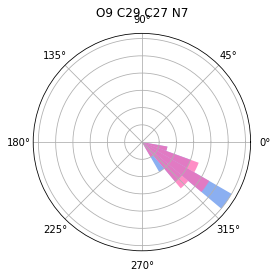

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


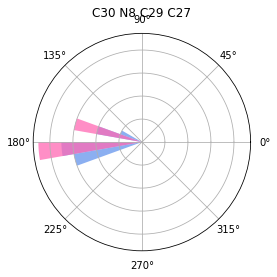

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


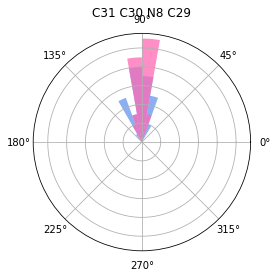

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


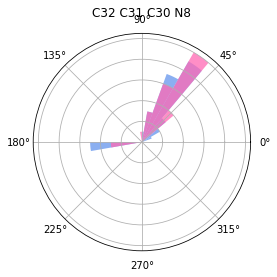

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


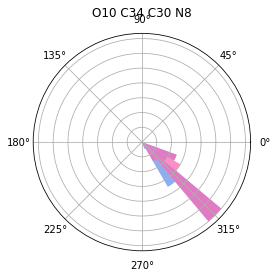

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


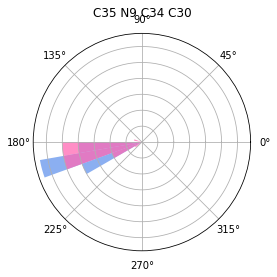

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


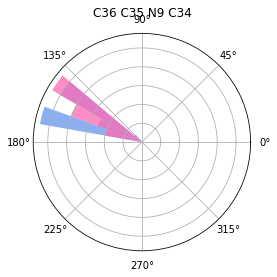

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


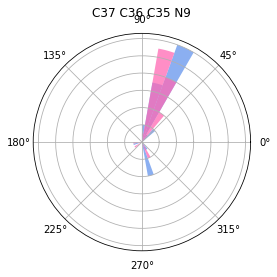

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


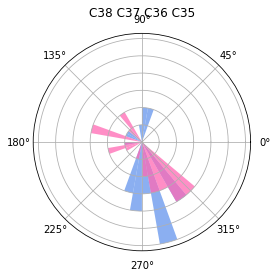

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


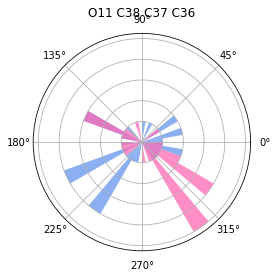

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


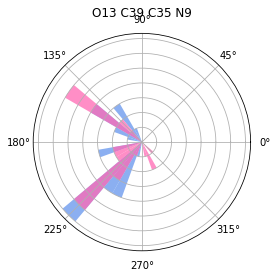

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


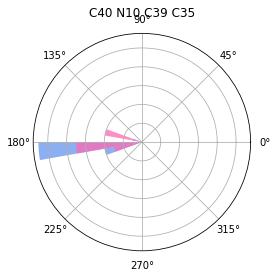

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


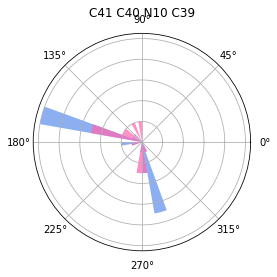

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


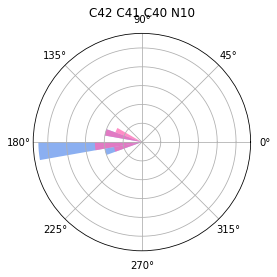

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


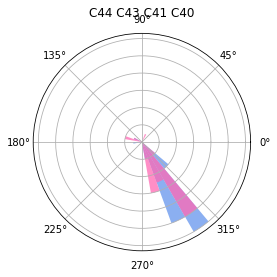

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


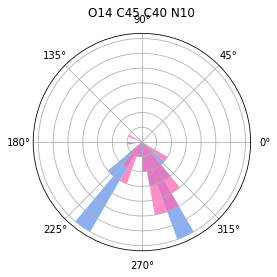

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


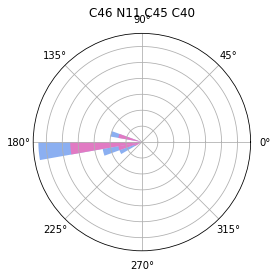

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


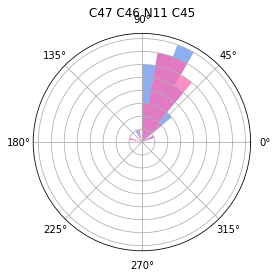

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


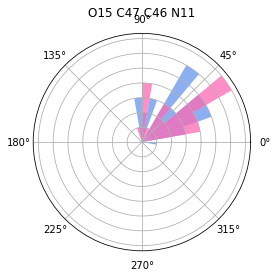

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


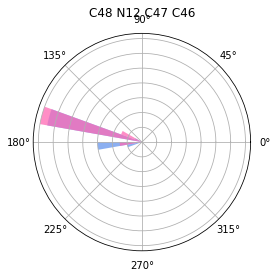

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


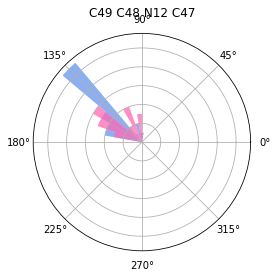

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


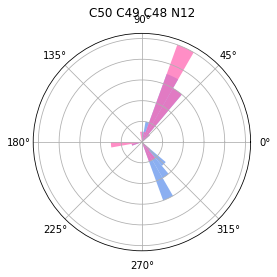

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


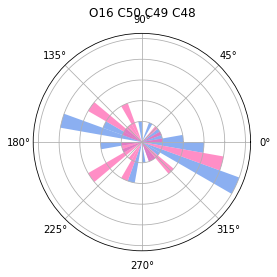

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


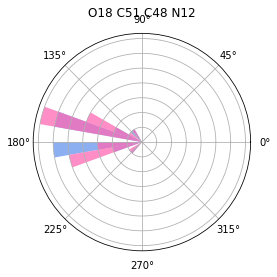

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


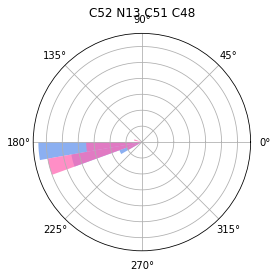

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


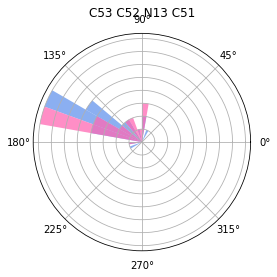

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


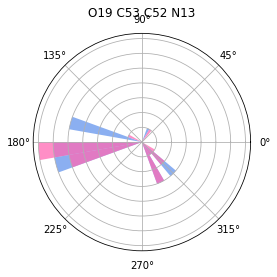

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


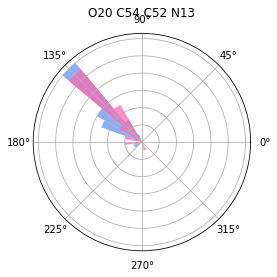

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


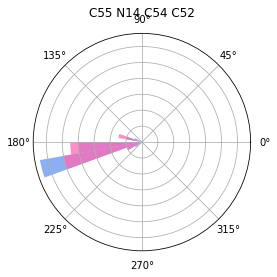

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


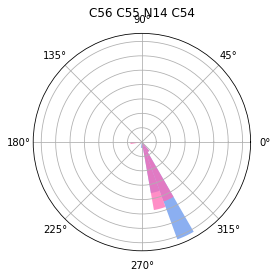

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


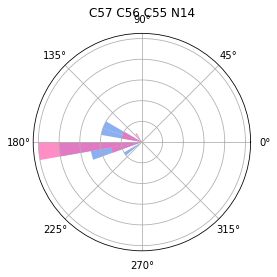

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


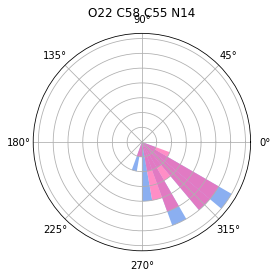

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


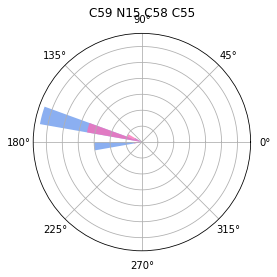

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


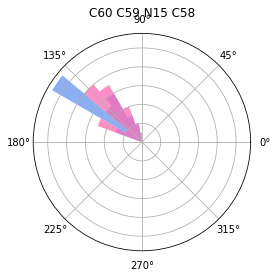

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


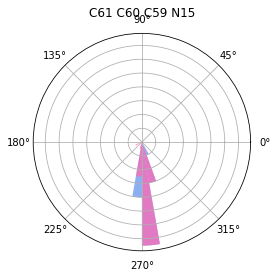

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


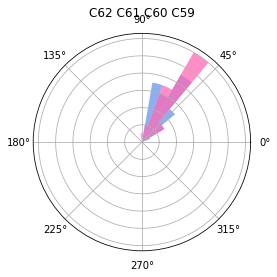

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


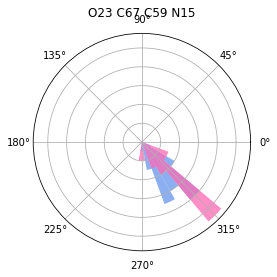

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


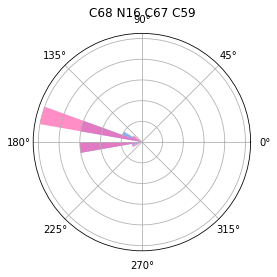

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


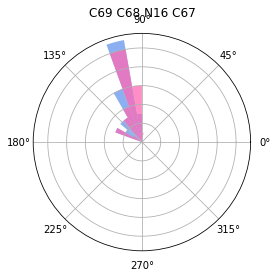

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


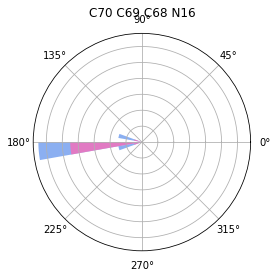

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


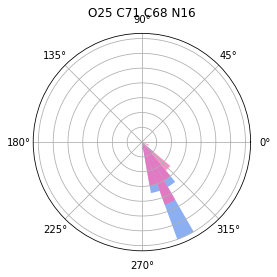

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


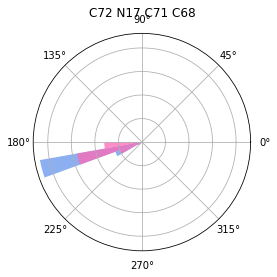

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


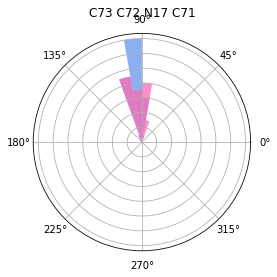

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


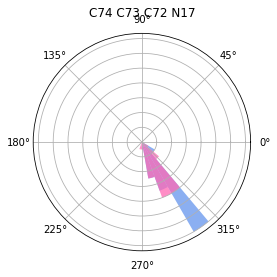

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


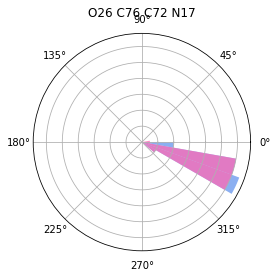

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


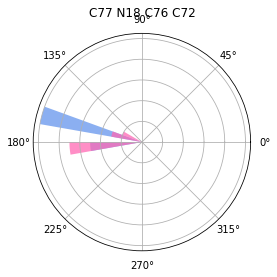

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


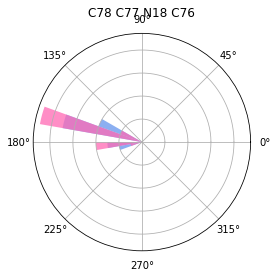

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


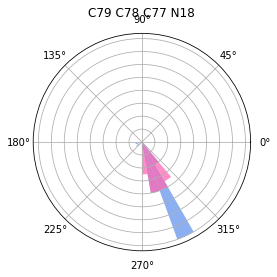

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


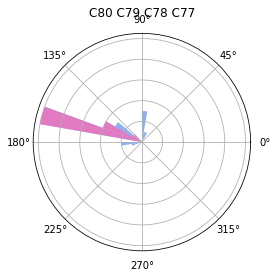

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


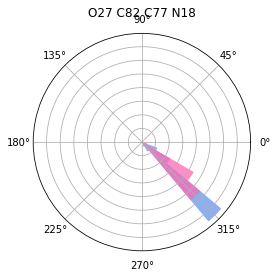

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


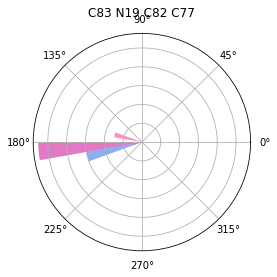

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


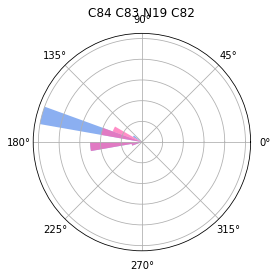

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


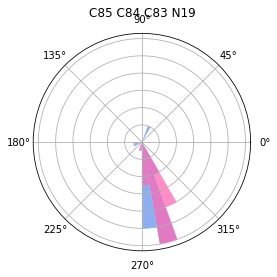

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


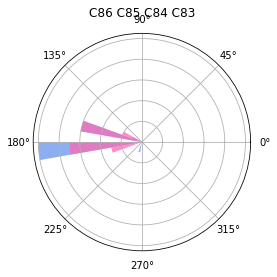

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


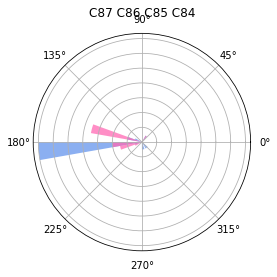

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


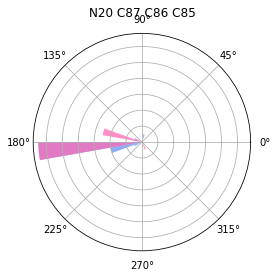

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


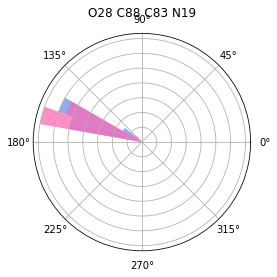

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


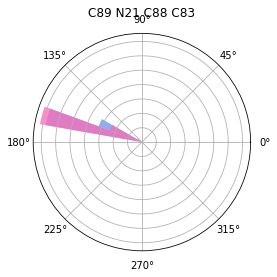

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


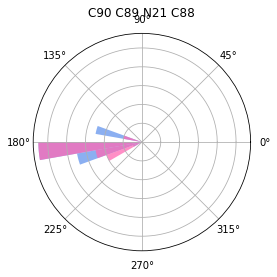

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


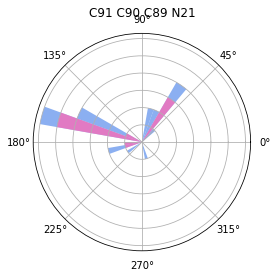

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


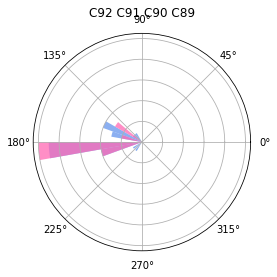

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


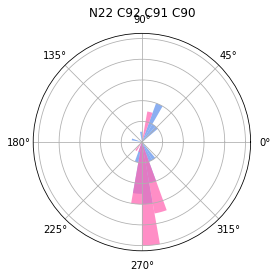

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


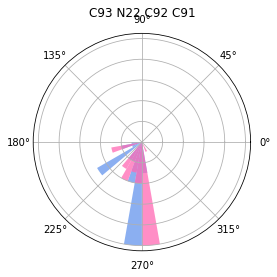

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


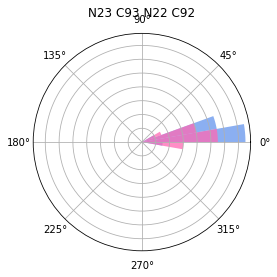

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


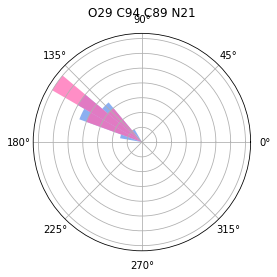

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


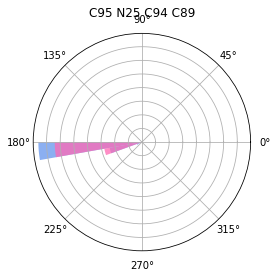

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


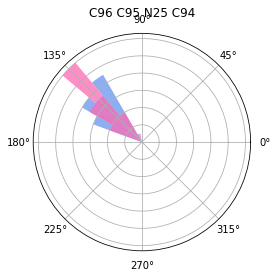

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


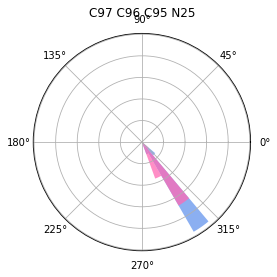

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


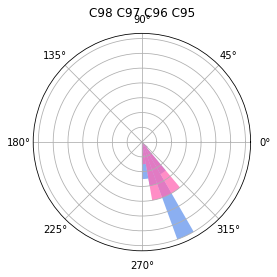

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


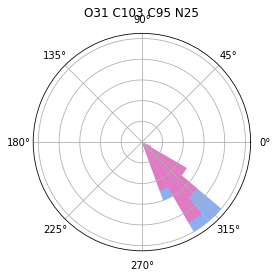

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


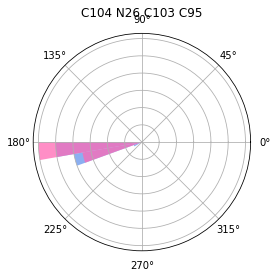

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


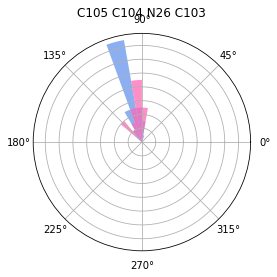

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


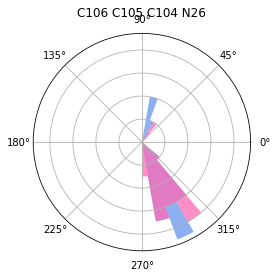

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


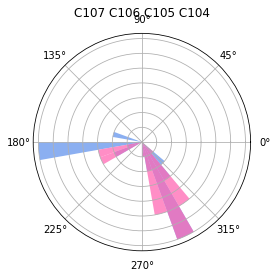

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


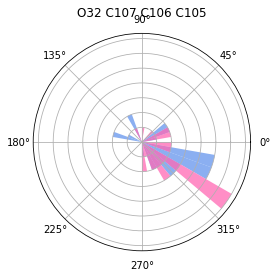

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


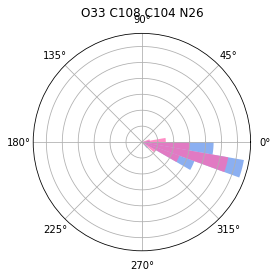

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


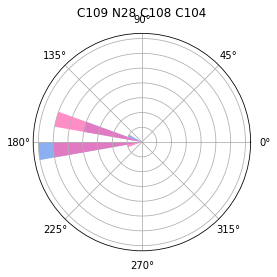

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


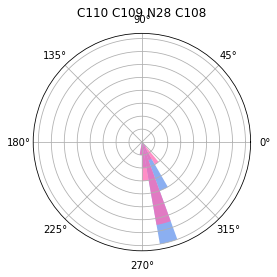

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


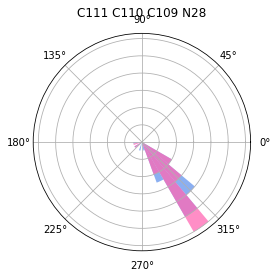

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


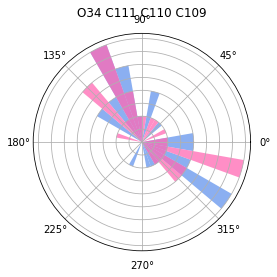

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


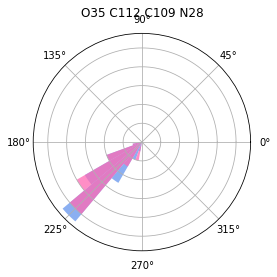

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


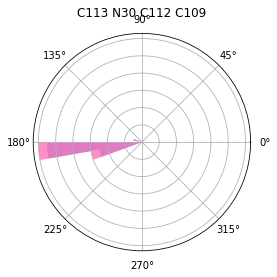

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


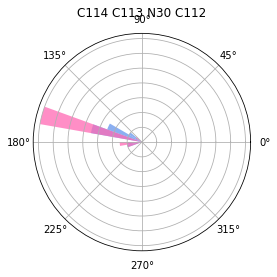

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


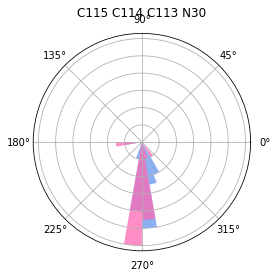

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


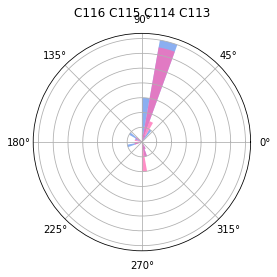

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


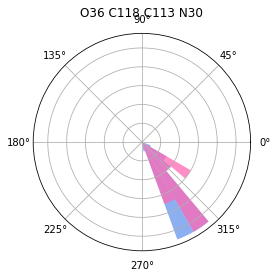

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


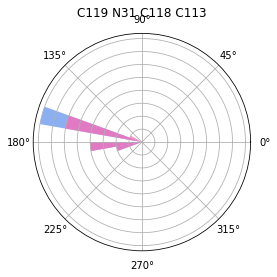

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


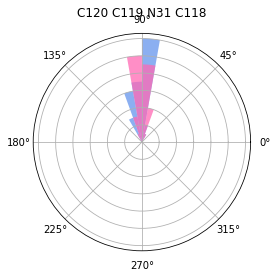

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


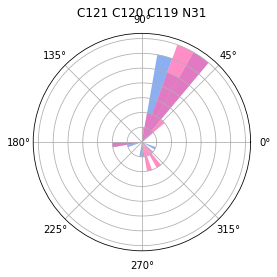

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


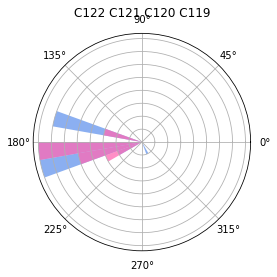

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


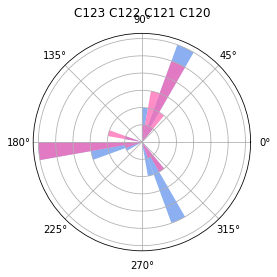

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


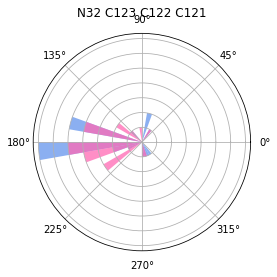

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


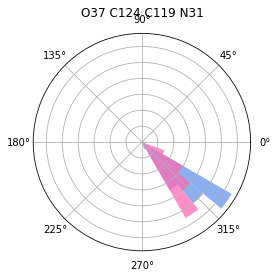

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


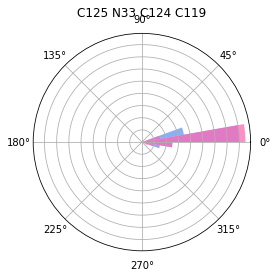

KeyError: 'O38 C129 C128 N33'

In [12]:
# Compute pie slices
N = 36 # in bins of 10 degree angles
bins = np.linspace(-np.pi, np.pi, N, endpoint=False)

for dihedral in results_MM.keys():
    MM = results_MM[dihedral]
    ANI = results_ANI[dihedral]
    ax = plt.subplot(111, projection='polar')
    ax.hist(MM,bins=bins, color='cornflowerblue', alpha=0.75)
    ax.hist(ANI,bins=bins, color='hotpink', alpha=0.75)
    ax.set_yticklabels('')
    ax.set_title(dihedral)
    plt.show()